In [1]:
import xarray as xr
import pandas as d
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
ice_vel = xr.load_dataset("/home/kim/data/nsidc/antarctic_ice_vel_phase_map_v01.nc")
# Define new variable: speed V 
ice_vel["V"] = ice_vel["VX"]**2 + ice_vel["VY"]**2

In [7]:
# Define corners in Antarctic Polar Stereographic coordinates (APSC)
x_min = 1_700_000
x_max = 2_700_000
y_min = - 1_400_000
y_max = - 400_000

# Define skiway coordinates
skiway_y = - 926_321.561224
skiway_x = 2_442_514.460804

ice_vel_casey = ice_vel.sel(
    x = slice(x_min, x_max), 
    y = slice(y_max, y_min))

## Custom colorscale

logarithmic color scale inspired by [this NASA article](https://earthobservatory.nasa.gov/images/146709/denman-glacier-losing-some-of-its-footing)

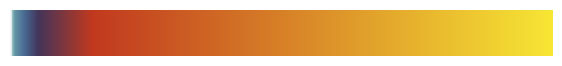

In [4]:
# Define color stops (positions from 0 to 1)
positions = [0.0, 0.1, 2.0, 5.0, 10.0, 50.0, 100.0, 300.0, 2000.0]  # uneven spacing
positions = np.array(positions) / 2000.0

# Define corresponding RGB or hex colors
colors = ["#eff5f8", "#CEE3E4", "#B3D2CD", "#9ACAC2", "#669AA8", "#486A93", "#43355B", "#C1391F", "#F7E634"]

# Create the custom colormap
icevel_cmap = LinearSegmentedColormap.from_list("custom_irregular", list(zip(positions, colors)))

# Display the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)

plt.figure(figsize = (7, 0.6))
plt.imshow(gradient, aspect = "auto", cmap = icevel_cmap)
plt.axis("off")
plt.show()

/home/kim/anaconda3/envs/dfngp_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


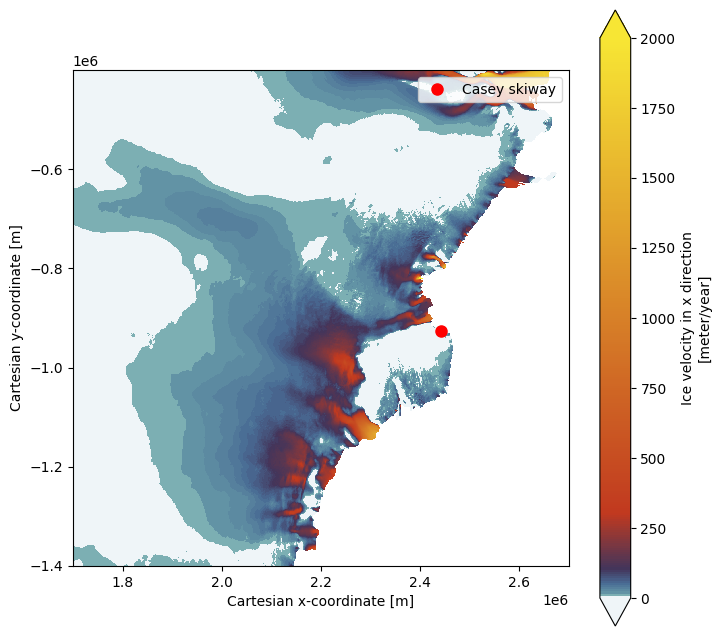

In [10]:
fig, ax = plt.subplots(figsize = (8, 8))

# Plot using pcolormesh
ice_vel_casey.VX.plot.pcolormesh(ax = ax, cmap = icevel_cmap, vmin = 0, vmax = 2000)

# Add a marker/dot for the skiway
ax.plot(skiway_x, skiway_y, "ro", markersize = 8, label = "Casey skiway")

ax.set_aspect("equal")
ax.legend()
plt.show()

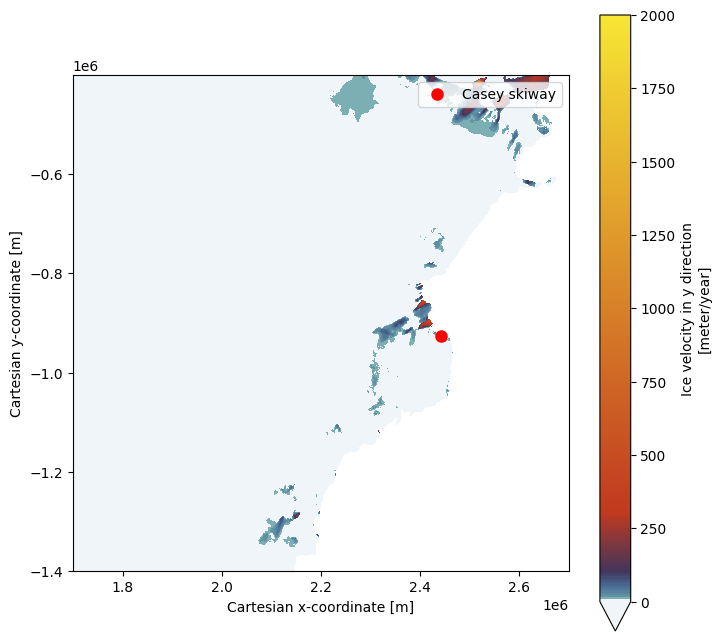

In [11]:
fig, ax = plt.subplots(figsize = (8, 8))

# Plot using pcolormesh
ice_vel_casey.VY.plot.pcolormesh(ax = ax, cmap = icevel_cmap, vmin = 0, vmax = 2000)

# Add a marker/dot for the skiway
ax.plot(skiway_x, skiway_y, "ro", markersize = 8, label = "Casey skiway")

ax.set_aspect("equal")
ax.legend()
plt.show()